<a href="https://colab.research.google.com/github/jolonia/pipeline/blob/main/Pipeline_w_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to Build Machine Learning Pipeline with Scikit-Learn? And Why is it essential?


Everybody should be using Pipeline. If you are not using it then you are probably doing it wrong – Andreas Mueller (scikit-learn core developer)

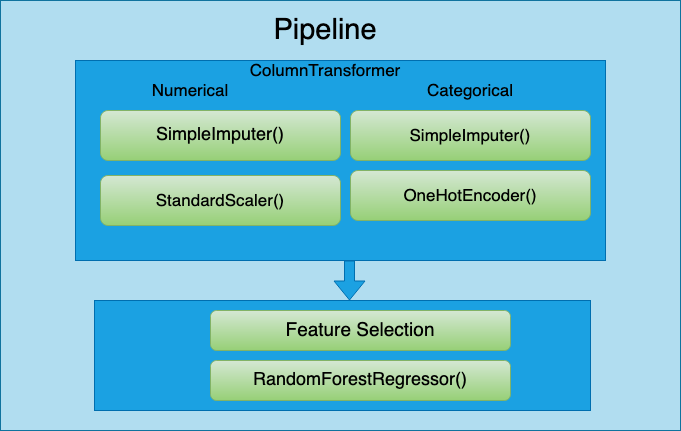

What is a Pipeline & Why is it essential?

Let’s say you want to build a machine learning model to predict the quality of red wine. A common workflow for solving this task would be as follows.

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# read the data and split it into a training and test set
url = "http://bit.ly/wine-quality-lwd"
wine = pd.read_csv(url)
X = wine.drop("quality", axis=1).copy()
y = wine["quality"].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Here, first, we read the data and split it into a training and a test set. Once we did that we need to prepare the data for machine learning before building the model like filling the missing value, scaling the data, doing one-hot encoding for categorical features etc.

In [ ]:
# fill missing values with medians
imputer = SimpleImputer(strategy="median")
X_train_tr = imputer.fit_transform(X_train)

# scale the data
scale = StandardScaler()
X_train_tr = scale.fit_transform(X_train_tr)

# do the same for test data. But here we will not apply the
# fit method only the transform method because we
# do not want our model to learn anything from the test data
X_test_tr = imputer.transform(X_test)
X_test_tr = scale.transform(X_test_tr)

Once we prepare the data, we can go forward and train the model on the training data and make predictions on the test data.



In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# initiate the k-nearest neighbors regressor class
knn = KNeighborsRegressor()
# train the knn model on training data
knn.fit(X_train_tr, y_train)
# make predictions on test data
y_pred = knn.predict(X_test_tr)
# measure the performance of the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

0.6729908369856655


As you can see there are lots of steps that need to be executed in the right order for training the model and If you mess things up, your model will be complete garbage. And this is just a simple example of an ml workflow. As you start working with a more complicated model, the chances of making errors are much higher. This is where the pipeline comes in.

#What is a pipeline?
A Pipeline is simply a method of chaining multiple steps together in which the output of the previous step is used as the input for the next step.
Let’s see how can we build the same model using a pipeline assuming we already split the data into a training and a test set.

In [ ]:
# list all the steps here for building the model
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)
# apply all the transformations on the training set and train an knn model
pipe.fit(X_train, y_train)
# apply all the transformations on the test set and make predictions
y_pred = pipe.predict(X_test)

# measure the performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

0.6729908369856655


That’s it. Every step of the model from start to finish is defined in a single step and Scikit-Learn did everything for you. First, it applied all the appropriate transformations on the training set and build the model on it when we call the fit method and then transform the test set and made the prediction when we call the predict method.

Pipeline helps you hide complexity just like functions do. It also helps you avoid leaking information from your test data into the trained model during cross-validation which we will see later in this post. It is easier to use and debug. If you don’t like something you can easily replace that step with something else without making too many changes to your code. It is also nicer for others to read and understand your code.

#How to use a Pipeline in Scikit-Learn?
The Pipeline in scikit-learn is built using a list of (key, value) pairs where the key is a string containing the name you want to give to a particular step and value is an estimator object for that step.

In [ ]:
from sklearn.pipeline import Pipeline

pipe_long = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",StandardScaler()),
    ("knn", KNeighborsRegressor())
])
pipe_long

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=5, p=2,
                                     weights='uniform'))],
         verbose=False)

There is also a shorthand syntax (make_pipeline) for making a pipeline that we saw earlier. It only takes the estimators and fills in the names automatically with the lowercase class names.


In [ ]:
pipe_short = make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor())
pipe_short

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsregressor',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=5, p=2,
                                     weights='uniform'))],
         verbose=False)

Rules for creating a Pipeline –
There are few rules that you need to follow when creating a Pipeline in scikit Learn.

1. All estimators in a pipeline, except the last one, must be transformers (i.e. must have a transform method) The last estimator may be any type (transformer, classifier, etc.).
2. Names for the steps can be anything you like as long as they are unique and don’t contain double underscores as they are used during hyperparameter tunning.

#Accessing Steps of a Pipeline –
The estimators of a pipeline are stored as a list in the steps attribute and can be accessed by index or by their name like this.

In [ ]:
print(pipe_long.steps[0]) # Accessed by step
print(pipe_long.steps[1])
print(pipe_long[2])
print(pipe_long["imputer"])

('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))
StandardScaler(copy=True, with_mean=True, with_std=True)


Pipeline’s named_steps attribute allows accessing steps by name with tab completion in interactive environments.



In [ ]:
pipe_long.named_steps.imputer

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

You can also use the slice notation to access them.

In [ ]:
print(pipe_long[1:])

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=5, p=2,
                                     weights='uniform'))],
         verbose=False)

#Grid Search using a Pipeline –
You can also do a grid search for hyperparameter optimization with a pipeline. And to access the parameters of the estimators in the pipeline using the <estimator>__<parameter> syntax.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# create a pipeline
pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)
# list of parameter values to try
param_grid = {
    "kneighborsregressor__n_neighbors": [3, 5, 8, 12, 15],
    "kneighborsregressor__weights": ["uniform", "distance"],
}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(algorithm='auto',
                             

Here, we wanted to set the numbers of neighbors parameters of the knn model so we use double underscore after the estimator name – kneighborsregressor__n_neighbors.

In [ ]:
# best score after grid search
print(np.sqrt(-grid.best_score_))
print(grid.best_estimator_)

0.6187124991308475
Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsregressor',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=15, p=2,
                                     weights='distance'))],
         verbose=False)


In [ ]:
# the estimators can be accessed like this
print(grid.best_estimator_.named_steps.kneighborsregressor)
print(grid.best_estimator_['kneighborsregressor'])

# and to access the nested parameters of the estimators
print(grid.best_estimator_.named_steps.kneighborsregressor.n_neighbors)
print(grid.best_estimator_["kneighborsregressor"].n_neighbors)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='distance')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='distance')
15
15


#We can go one step further.
So far, we only worked with a single algorithm(K-Nearest Neighbors) but many other algorithms might perform better than this. So, now let’s try different algorithms and see which perform best and we will also try different options for preparing the data as well, everything in a single step.

In [ ]:
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# pipeline for the model
pipe = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor()),
    ]
)

# model tunning with GridSearch
param_grid = {
    "imputer__strategy": ["mean", "median", "most_frequent", "constant"],
    "scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
    "regressor": [
        KNeighborsRegressor(),
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        DecisionTreeRegressor(random_state=42),
        XGBRegressor(objective = 'reg:squarederror', random_state=42),
    ],
}


grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)

print(grid.fit(X_train, y_train))
print(np.sqrt(-grid.best_score_))

0.6076141317775702


Here, we tried 5 different algorithms with default values and we also tested the scaler and imputer method that works best with them. The best algorithm for this task is the RandomForestRegressor which is scaled and the mean is used to fill the missing values. Some other models that performed well are XGBRegressor and LinearRegression.

As we narrow down the few algorithms that are performing well on this dataset, we can further improve the result by tuning the parameters of these models separately with different settings. Here, we are using separate dictionaries for each of the algorithms that we want to tune.

In [ ]:
# make the pipeline and do grid search
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor()),
    ]
)

param_grid = [
    {
        "regressor": [RandomForestRegressor(random_state=42)],
        "regressor__n_estimators": [100, 300, 500, 1000],
        "regressor__max_depth": [3, 5, 8, 15],
        "regressor__max_features": ["log2", "sqrt", "auto"],
    },
    {
        "regressor": [XGBRegressor(objective = 'reg:squarederror', random_state=42)],
        "regressor__max_depth": [3, 5, 8, 15],
        "regressor__learning_rate": [0.1, 0.01, 0.05],
        "regressor__gamma": [0, 0.25, 1.0],
        "regressor__lambda": [0, 1.0, 10.0],
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regressor',
                                        RandomForestRegressor(bootstrap=True,
                                                       

In [ ]:
# best model
print(grid.best_estimator_)
print(np.sqrt(-grid.best_score_))

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=15,
                                       max_features='log2', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=1000, n_jobs=Non

#ColumnTransformer with Pipelines –

So far, we only worked with numerical data to keep things simple but this is not going to be the case always. You are also going to have some categorical data like sex(Male, Female) and you can’t apply the same transformation like mean and median to it. You have to apply a different transformation to the categorical data.

One of the easiest ways we can apply a different transformation to numerical and categorical columns in scikit-learn is by using the ColumnTransformer.

We will read a new data set which has mixed data type(numerical and categorical) and see how to apply everything that we have learned so far using a pipeline

In [ ]:
import pandas as pd
import numpy as np

# read the happiness data
url = "http://bit.ly/happiness-2019"
happiness = pd.read_csv(url)
happiness.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [ ]:
# create a training and a test set
X = happiness.drop(["Overall rank", "Score"], axis=1).copy()
y = happiness["Score"].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
X

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Finland,1.340,1.587,0.986,0.596,0.153,0.393
1,Denmark,1.383,1.573,0.996,0.592,0.252,0.410
2,Norway,1.488,1.582,1.028,0.603,0.271,0.341
3,Iceland,1.380,1.624,1.026,0.591,0.354,0.118
4,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298
...,...,...,...,...,...,...,...
151,Rwanda,0.359,0.711,0.614,0.555,0.217,0.411
152,Tanzania,0.476,0.885,0.499,0.417,0.276,0.147
153,Afghanistan,0.350,0.517,0.361,0.000,0.158,0.025
154,Central African Republic,0.026,0.000,0.105,0.225,0.235,0.035


In [ ]:
y

0      7.769
1      7.600
2      7.554
3      7.494
4      7.488
       ...  
151    3.334
152    3.231
153    3.203
154    3.083
155    2.853
Name: Score, Length: 156, dtype: float64

Now, we will build separate pipelines for numerical and categorical data and combine them using columnTransformer that applies appropriate transformations based on the column data type.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# first select the numerical and categorical columns
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

# pipeline for numerical data
num_preprocessing = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

# combine both pipeline using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing, cat_cols)]
)

preprocessing

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
               

In [ ]:
cat_cols

['Country or region']

The ColumnTransformer requires a list of tuples where each tuple contains a name, a transformer, and a list of names(or indices) of columns that the transformer should be applied to.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# make a new pipeline that does everything
full_pipe = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

# measure model performance using cross-validation
scores = cross_val_score(
    full_pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
# rmse
print(np.mean(np.sqrt(-scores)))

0.47931931211228107


Here it is. We created a pipeline that encapsulates every step of the process that needs to be done to create the model. Isn’t this awesome? Nice and simple.

we can also do a grid search as before.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "preprocess__num__simpleimputer__strategy": ["mean", "median", "constant"],
    "regressor__n_estimators": [100, 300, 500],
    "regressor__max_depth": [1, 3, 5, 8],
}

grid = GridSearchCV(
    full_pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [ ]:
# rmse
print(np.sqrt(-grid.best_score_))

# To access the estimator
print(grid.best_estimator_.named_steps.regressor)

# To access the transformers
# print(grid.best_estimator_.named_steps.preprocess.transformers_[0])
# print(grid.best_estimator_.named_steps.preprocess.transformers_[1])

# best hyperparameters
print(grid.best_params_)
{'preprocess__num__simpleimputer__strategy': 'mean', 'regressor__max_depth': 8, 'regressor__n_estimators': 300}

0.4810274797416705
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
{'preprocess__num__simpleimputer__strategy': 'mean', 'regressor__max_depth': 8, 'regressor__n_estimators': 300}


{'preprocess__num__simpleimputer__strategy': 'mean',
 'regressor__max_depth': 8,
 'regressor__n_estimators': 300}

#We created a model from scratch and did everything using a pipeline!